# Kalman Filter
> Implementation of Kalman filters using pytorch and parameter optimizations with gradient descend

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
#| default_exp kalman.filter

In [ ]:
#| export
from fastcore.test import *
from fastcore.basics import *
from meteo_imp.utils import *
from meteo_imp.gaussian import *
from meteo_imp.data_preparation import MeteoDataTest
from typing import *

import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.distributions import MultivariateNormal

## Introduction

### Utils

In [ ]:
#| exporti
def array1d(X):
    """Returns at least 1-d array with data from X"""
    return torch.atleast_1d(torch.as_tensor(X))

def array2d(X):
    """Returns at least 2-d array with data from X"""
    return torch.atleast_2d(torch.as_tensor(X))


In [ ]:
#| export
def _determine_dimensionality(variables, default):
    """Derive the dimensionality of the state space

    Parameters
    ----------
    variables : list of ({None, array}, conversion function, index)
        variables, functions to convert them to arrays, and indices in those
        arrays to derive dimensionality from.
        
    Returns
    -------
    dim : int
        dimensionality of state space as derived from variables or default.
    """
    # gather possible values based on the variables
    candidates = []
    for (v, converter, idx) in variables:
        if v is not None:
            v = converter(v)
            candidates.append(v.shape[idx])
    
     # also use the manually specified default
    if default is not None:
        candidates.append(default)
    
    # ensure consistency of all derived values
    if len(candidates) == 0:
        return 1
    else:
        if not torch.all(torch.tensor(candidates) == candidates[0]):
            raise ValueError(
                "The shape of all " +
                "parameters is not consistent.  " +
                "Please re-check their values."
            )
        return candidates[0]


def _last_dims(X: Tensor, t: int, ndims: int=2):
    """Extract the final dimensions of `X`

    Extract the final `ndim` dimensions at index `t` if `X` has >= `ndim` + 1
    dimensions, otherwise return `X`.

    Parameters
    ----------
    X : Tensor with at least dimension `ndims`
    t : int
        index to use for the `ndims` + 1th dimension
    ndims : int, optional
        number of dimensions in the array desired

    Returns
    -------
    Y : array with dimension `ndims`
        the final `ndims` dimensions indexed by `t`
    """
    if len(X.shape) == ndims + 1:
        return X[t]
    elif len(X.shape) == ndims:
        return X
    else:
        raise ValueError(("X only has %d dimensions when %d" +
                " or more are required") % (len(X.shape), ndims))

In [ ]:
#| export
def _stack_detach(l: Collection[Tensor]):
    return torch.stack(list(map(lambda x: x.detach(), l)))

### Positive Definite Constraint

The covariance matrices need to be [positive definite](https://en.wikipedia.org/wiki/Definite_matrix)
Those are utilities functions to check is a matrix is positive definite and to make any matrix positive definite

In [ ]:
A = torch.rand(3,3) # random matrix used for testing

#### Symmetry

In [ ]:
#| export
def is_symmetric(value, atol=1e-5):
    return torch.isclose(value, value.mT, atol=atol).all().item()

In [ ]:
is_symmetric(A)

False

In [ ]:
#| export
def symmetric_upto(value, start=-8):
    for exp in torch.arange(start, 3):
        if is_symmetric(value, atol=10**exp):
            return exp.item()
    return exp.item()

In [ ]:
symmetric_upto(A)

0

#### is posdef

Default pytorch check (uses symmetry + cholesky decomposition)

In [ ]:
#| export
def is_posdef(cov):
    return torch.distributions.constraints.positive_definite.check(cov).item()

In [ ]:
is_posdef(A)

False

check if it is pos definite using eigenvalues. Positive definite matrix have all positive eigenvalues

In [ ]:
torch.linalg.eigvalsh(A)

tensor([-0.5442,  0.1242,  0.9816])

In [ ]:
#| export
def is_posdef_eigv(cov):
    eigv = torch.linalg.eigvalsh(cov)
    if (eigv < 0).any():
        return False, eigv
    return True, eigv

In [ ]:
is_posdef_eigv(A)

(False, tensor([-0.5442,  0.1242,  0.9816]))

Note that `is_posdef` and `is_posdef_eigv` can return different values, in general `is_posdef_eigv` is more tollerant

transform any matrix $A$ into a positive definite matrix ($PD$) using the following formula

$PD = CC^T$ where $C$ is the lower triangular matrix of $A$

the inverse transformation uses cholesky decomposition


The API inspired by gpytorch constraints

In [ ]:
#| export
class PosDef():
    """ Positive Definite Constraint for PyTorch parameters"""
    def transform(self,
                  raw # square matrix
                 ):
        """transform any matrix into a positive definite one"""
        C = torch.tril(raw)
        return C @ C.mT
    
    def inverse_transform(self,
                          value # a positive definite matrix
                         ):
        """tranform positive definite matrix into a matrix that can be back_transformed using `transform`"""
        return torch.linalg.cholesky(value)

to_posdef = PosDef().transform

In [ ]:
constraint = PosDef()

posdef = constraint.transform(A)

In [ ]:
A

tensor([[0.3427, 0.1567, 0.1184],
        [0.3918, 0.2086, 0.9520],
        [0.1444, 0.6186, 0.0103]])

In [ ]:
posdef

tensor([[0.1175, 0.1343, 0.0495],
        [0.1343, 0.1970, 0.1857],
        [0.0495, 0.1857, 0.4037]])

In [ ]:
test_eq(is_posdef(posdef), True)

In [ ]:
constraint.inverse_transform(posdef)

tensor([[0.3427, 0.0000, 0.0000],
        [0.3918, 0.2086, 0.0000],
        [0.1444, 0.6186, 0.0103]])

In [ ]:
test_close(posdef, constraint.transform(constraint.inverse_transform(posdef)))

In [ ]:
is_symmetric(posdef)

True

In [ ]:
symmetric_upto(posdef)

-8

In [ ]:
is_posdef_eigv(posdef)

(True, tensor([5.6563e-06, 1.7525e-01, 5.4292e-01]))

#### Check pos def

This is to help finding matrices that aren't positive definite and debug the issues.
Returns a detailed dataframe row with info about the matrix and optionally logs everything to a global object

In [ ]:
#| export
from warnings import warn

In [ ]:
#| export
class CheckPosDef():
    def __init__(self,
                do_check:bool = False, # set to True to actually check matrix
                use_log:bool = True, # keep internal log
                warning:bool = True, # show a warning if a matrix is not pos def 
                ):
        store_attr()
        self.log = pd.DataFrame()
        self.extra_args = {}
    def add_args(self, **kwargs):
        """Add an extra argument to the next call of check_posdef """
        self.extra_args = {**kwargs, **self.extra_args}
        return self
    
    def check(self,
              x: Tensor, # (batch of) square matrix
              **extra_args
             ) -> pd.DataFrame:
        
        if not self.do_check: return
        
        self.add_args(**extra_args)
        
        x = x if x.dim() > 2 else [x]
        infos = pd.concat([*map(self._check_matrix, x)])
        
        if self.use_log: self.log = pd.concat([self.log, infos])
        if self.warning and (~infos['is_pd_eigv'].all() or ~infos['is_pd_chol'].all()):
             warn("Matrix is not positive definite")
        
        self.extra_args = {} 
        return infos
    
    def _check_matrix(self,
                     x: Tensor # square matrix
                    ) -> pd.DataFrame:
        
        x = x.detach().cpu().clone() # free GPU memory and ensure that there is a copy
        sym_upto = symmetric_upto(x)

        is_pd_eigv, eigv = is_posdef_eigv(x)
        is_pd_chol = torch.linalg.cholesky_ex(x).info.eq(0).all().item() # skip pytorch too strict symmetry check
        is_sym = is_symmetric(x)

        info = pd.DataFrame({
            'is_pd_eigv': is_pd_eigv,
            'is_pd_chol': is_pd_chol,
            'is_sym': is_sym,
            'sym_upto': sym_upto,
            'eigv': [eigv.detach().numpy()],
            'matrix': [x.detach().numpy()],
            **self.extra_args
        })

        return info

In [ ]:
CheckPosDef(True).check(A)

/tmp/ipykernel_16010/838933125.py:29: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")


,is_pd_eigv,is_pd_chol,is_sym,sym_upto,eigv,matrix
0,False,False,False,0,"[-0.5442282, 0.12421053, 0.9816487]","[[0.34273952, 0.1567195, 0.11838853], [0.39177..."


In [ ]:
checker = CheckPosDef(True)

checker.check(A, my_arg="my arg") # this will be another col in the log

/tmp/ipykernel_16010/838933125.py:29: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")


,is_pd_eigv,is_pd_chol,is_sym,sym_upto,eigv,matrix,my_arg
0,False,False,False,0,"[-0.5442282, 0.12421053, 0.9816487]","[[0.34273952, 0.1567195, 0.11838853], [0.39177...",my arg


In [ ]:
checker.log

,is_pd_eigv,is_pd_chol,is_sym,sym_upto,eigv,matrix,my_arg
0,False,False,False,0,"[-0.5442282, 0.12421053, 0.9816487]","[[0.34273952, 0.1567195, 0.11838853], [0.39177...",my arg


In [ ]:
checker.add_args(show="only once")
checker.check(posdef)
checker.check(A)
checker.log

/tmp/ipykernel_16010/838933125.py:29: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")


,is_pd_eigv,is_pd_chol,is_sym,sym_upto,eigv,matrix,my_arg,show
0,False,False,False,0,"[-0.5442282, 0.12421053, 0.9816487]","[[0.34273952, 0.1567195, 0.11838853], [0.39177...",my arg,NaN
0,True,True,True,-8,"[5.6563063e-06, 0.17524819, 0.5429207]","[[0.11747038, 0.13427578, 0.04950164], [0.1342...",NaN,only once
0,False,False,False,0,"[-0.5442282, 0.12421053, 0.9816487]","[[0.34273952, 0.1567195, 0.11838853], [0.39177...",NaN,NaN


In [ ]:
B = torch.rand(2,3,3) # a batch of matrices

In [ ]:
checker.check(B)

/tmp/ipykernel_16010/838933125.py:29: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")


,is_pd_eigv,is_pd_chol,is_sym,sym_upto,eigv,matrix
0,False,False,False,0,"[-0.6299121, 0.10874571, 1.2889841]","[[0.27296227, 0.2163598, 0.11539459], [0.09705..."
0,True,True,False,0,"[0.17793366, 0.627806, 1.3450105]","[[0.75479823, 0.50660074, 0.55367833], [0.4830..."


In [ ]:
test_close(B[0] @ A, (B @ A)[0]) # example batched matrix multiplication

## KalmanFilter

The Kalman Filter is an algorithm designed to estimate $P(x_t | y_{0:t})$.  As all state transitions and obss are linear with Gaussian distributed noise, these distributions can be represented exactly as Gaussian distributions with mean `filt_state_means[t]` and covs `filt_state_covs[t]`.
Similarly, the Kalman Smoother is an algorithm designed to estimate $P(x_t | y_{0:T-1})$



### Main class

In [ ]:
#| export
class KalmanFilter(torch.nn.Module):
    """Kalman Filter and Smoother using PyTorch"""
    def __init__(self,
            trans_matrix: Tensor,    # [n_dim_state,n_dim_state] $A$, state transition matrix 
            obs_matrix: Tensor,      # [n_dim_obs, n_dim_state] $H$, observation matrix
            trans_cov: Tensor,       # [n_dim_state, n_dim_state] $Q$, state trans covariance matrix
            obs_cov: Tensor,         # [n_dim_obs, n_dim_obs] $R$, observations covariance matrix
            trans_off: Tensor,       # [n_dim_state] $b$, state transition offset
            obs_off: Tensor,         # [n_dim_obs] $d$, observations offset
            init_state_mean: Tensor, # [n_dim_state] $\mu_0"$
            init_state_cov: Tensor,  # [n_dim_state, n_dim_state] $\Sigma_0$
            n_dim_state: int = None, # Number of dimensions for state - defaults to 1 if cannot be infered from parameters
            n_dim_obs: int = None,   # Number of dimensions for observations - defaults to 1 if cannot be infered from parameters
            cov_checker: CheckPosDef = CheckPosDef()
                ):
        
        super().__init__()
        # check parameters are consistent
        self.n_dim_state = _determine_dimensionality(
            [(trans_matrix, array2d, -2),
             (trans_off, array1d, -1),
             (trans_cov, array2d, -2),
             (init_state_mean, array1d, -1),
             (init_state_cov, array2d, -2),
             (obs_matrix, array2d, -1)],
            n_dim_state
        )
        self.n_dim_obs = _determine_dimensionality(
            [(obs_matrix, array2d, -2),
             (obs_off, array1d, -1),
             (obs_cov, array2d, -2)],
            n_dim_obs
        )
        
        params = {
        #name               value             constraint
        'trans_matrix':     [trans_matrix,    None    ],
        'trans_off':        [trans_off,       None    ],
        'trans_cov':        [trans_cov,       PosDef()],
        'obs_matrix':       [obs_matrix,      None    ],
        'obs_off':          [obs_off,         None    ],
        'obs_cov':          [obs_cov,         PosDef()],
        'init_state_mean':  [init_state_mean, None    ],
        'init_state_cov':   [init_state_cov,  PosDef()],
        }
        self._init_params(params)
        
        self.cov_checker = cov_checker
        
    def _init_params(self, params):
        for name, (value, constraint) in params.items():
            if constraint is not None:
                name, value = self._init_constraint(name, value, constraint)
            self._init_param(name, value, train=True)    
    
    def _init_param(self, param_name, value, train):
        self.register_parameter(param_name, torch.nn.Parameter(value, requires_grad=train))
    
    ### === Constraints utils
    def _init_constraint(self, param_name, value, constraint):
        name = param_name + "_raw"
        value = constraint.inverse_transform(value)
        setattr(self, param_name + "_constraint", constraint)
        return name, value
    
    def _get_constraint(self, param_name):
        constraint = getattr(self, param_name + "_constraint")
        raw_value = getattr(self, param_name + "_raw")
        return constraint.transform(raw_value)
    
    def _set_constraint(self, param_name, value, train=True):
        constraint = getattr(self, param_name + "_constraint")
        raw_value = constraint.inverse_transform(value)
        self._init_param(param_name + "_raw", raw_value, train)
    
    ### === Convenience functions to get and set parameters that have a constraint
    @property
    def trans_cov(self): return self._get_constraint('trans_cov')
    @trans_cov.setter
    def trans_cov(self, value): return self._set_constraint('trans_cov', value)

    @property
    def obs_cov(self): return self._get_constraint('obs_cov')
    @obs_cov.setter
    def obs_cov(self, value): return self._set_constraint('obs_cov', value)
    
    @property
    def init_state_cov(self): return self._get_constraint('init_state_cov')
    @init_state_cov.setter
    def init_state_cov(self, value): return self._set_constraint('init_state_cov', value)
    
    
    ### === Utility Func    
    def _parse_obs(self, obs, mask=None):
        """get mask from `nan`"""
        if mask is None: mask = ~torch.isnan(obs)
        return obs, mask
    
    def __repr__(self):
        return f"""Kalman Filter
        N dim obs: {self.n_dim_obs}, N dim state: {self.n_dim_state}"""

### Constructors

Giving all the parameters manually to the `KalmanFilter` init method is not convenient, hence we are having some methods that help initize the class

#### Random parameters

In [ ]:
@patch(cls_method=True)
def init_random(cls: KalmanFilter, n_dim_obs, n_dim_state, dtype=torch.float32):
    """kalman filter with random parameters"""
    params = {
        'trans_matrix':    torch.rand(n_dim_state, n_dim_state, dtype=dtype),
        'trans_off':       torch.rand(n_dim_state, dtype=dtype),        
        'trans_cov':       to_posdef(torch.rand(n_dim_state, n_dim_state, dtype=dtype)),        
        'obs_matrix':      torch.rand(n_dim_obs, n_dim_state, dtype=dtype),
        'obs_off':         torch.rand(n_dim_obs, dtype=dtype),          
        'obs_cov':         to_posdef(torch.rand(n_dim_obs, n_dim_obs, dtype=dtype)),            
        'init_state_mean': torch.rand(n_dim_state, dtype=dtype),        
        'init_state_cov':  to_posdef(torch.rand(n_dim_state, n_dim_state, dtype=dtype)),
    } 
    return cls(**params) 
        

In [ ]:
k = KalmanFilter.init_random(3,4, dtype=torch.float64)
k

Kalman Filter
        N dim obs: 3, N dim state: 4

In [ ]:
k.init_state_cov

tensor([[0.8016, 0.6772, 0.3551, 0.2307],
        [0.6772, 1.0154, 0.3157, 0.8042],
        [0.3551, 0.3157, 0.4873, 0.4452],
        [0.2307, 0.8042, 0.4452, 1.8951]], dtype=torch.float64,
       grad_fn=<MmBackward0>)

check that assigment works :)

In [ ]:
k.init_state_cov = to_posdef(torch.rand(4, 4, dtype=torch.float64))

In [ ]:
k.init_state_cov_raw

Parameter containing:
tensor([[0.9134, 0.0000, 0.0000, 0.0000],
        [0.1470, 0.0317, 0.0000, 0.0000],
        [0.0246, 0.7401, 0.5663, 0.0000],
        [0.8266, 0.2884, 0.4673, 0.5200]], dtype=torch.float64,
       requires_grad=True)

In [ ]:
list(k.named_parameters())

[('trans_matrix',
  Parameter containing:
  tensor([[0.2465, 0.6241, 0.0668, 0.2462],
          [0.3628, 0.9695, 0.1732, 0.8691],
          [0.7322, 0.6460, 0.8722, 0.1543],
          [0.1916, 0.7642, 0.8182, 0.6880]], dtype=torch.float64,
         requires_grad=True)),
 ('trans_off',
  Parameter containing:
  tensor([0.4932, 0.3893, 0.5000, 0.5153], dtype=torch.float64,
         requires_grad=True)),
 ('trans_cov_raw',
  Parameter containing:
  tensor([[0.5359, 0.0000, 0.0000, 0.0000],
          [0.3731, 0.5537, 0.0000, 0.0000],
          [0.8140, 0.5295, 0.8536, 0.0000],
          [0.3290, 0.3177, 0.9150, 0.2056]], dtype=torch.float64,
         requires_grad=True)),
 ('obs_matrix',
  Parameter containing:
  tensor([[0.9469, 0.4173, 0.8337, 0.0245],
          [0.5583, 0.7074, 0.2610, 0.9702],
          [0.3830, 0.6747, 0.3639, 0.4944]], dtype=torch.float64,
         requires_grad=True)),
 ('obs_off',
  Parameter containing:
  tensor([0.2422, 0.5051, 0.0628], dtype=torch.float64, requi

#### Simple parameters

In [ ]:
@patch(cls_method=True)
def init_simple(cls: KalmanFilter,
                n_dim, # n_dim_obs and n_dim_state
                dtype=torch.float32):
    """Simplest version of kalman filter parameters"""
    return cls(
        trans_matrix =     torch.eye(n_dim, dtype=dtype),
        trans_off =        torch.zeros(n_dim, dtype=dtype),        
        trans_cov =        torch.eye(n_dim, dtype=dtype),        
        obs_matrix =       torch.eye(n_dim, dtype=dtype),
        obs_off =          torch.zeros(n_dim, dtype=dtype),          
        obs_cov =          torch.eye(n_dim, dtype=dtype),            
        init_state_mean =  torch.zeros(n_dim, dtype=dtype),        
        init_state_cov =   torch.eye(n_dim, dtype=dtype),
    )

In [ ]:
KalmanFilter.init_simple(2).state_dict()

OrderedDict([('trans_matrix',
              tensor([[1., 0.],
                      [0., 1.]])),
             ('trans_off', tensor([0., 0.])),
             ('trans_cov_raw',
              tensor([[1., 0.],
                      [0., 1.]])),
             ('obs_matrix',
              tensor([[1., 0.],
                      [0., 1.]])),
             ('obs_off', tensor([0., 0.])),
             ('obs_cov_raw',
              tensor([[1., 0.],
                      [0., 1.]])),
             ('init_state_mean', tensor([0., 0.])),
             ('init_state_cov_raw',
              tensor([[1., 0.],
                      [0., 1.]]))])

### Test data

In [ ]:
def get_test_data(n_obs = 10, n_dim_obs=3, p_missing=.3, bs=2, dtype=torch.float32):
    data = torch.rand(bs, n_obs, n_dim_obs, dtype=dtype)
    mask = torch.rand(bs, n_obs, n_dim_obs) > p_missing
    data[~mask] = torch.nan # ensure that the missing data cannot be used
    return data, mask

In [ ]:
reset_seed()
data, mask = get_test_data()
show_as_row(data, mask)

### Filter

#### Filter predict

Probability of state at time `t` given state a time `t-1` 

$p(x_t) = \mathcal{N}(x_t; m_t^-, P_t^-)$ where:

- predicted state mean: $m_t^- = Am_{t-1} + B c_t + b$  

- predicted state covariance: $P_t^- = AP_{t-1}A^T + Q$

In [ ]:
#| export
from datetime import datetime
def _filter_predict(trans_matrix,
                    trans_cov,
                    trans_off,
                    curr_state_mean,
                    curr_state_cov,
                    control_matrix=0,
                    control=0,
                    cov_checker=CheckPosDef()):
    r"""Calculate the state at time `t+1` given the state at time `t`"""
    pred_state_mean = trans_matrix.unsqueeze(0) @ curr_state_mean + trans_off.unsqueeze(-1)
    pred_state_cov =  trans_matrix.unsqueeze(0) @ curr_state_cov @ trans_matrix.unsqueeze(0).mT + trans_cov.unsqueeze(0)

    cov_checker.check(pred_state_cov, caller='filter_predict')
    return (pred_state_mean, pred_state_cov)

In [ ]:
trans_matrix, trans_cov, trans_off,curr_state_mean,curr_state_cov = (k.trans_matrix, k.trans_cov, k.trans_off,
                                                  torch.stack([k.init_state_mean]*2).unsqueeze(-1),
                                                  torch.stack([k.init_state_cov]*2))

In [ ]:
pred_state_mean, pred_state_cov = _filter_predict(trans_matrix, trans_cov, trans_off,curr_state_mean,curr_state_cov)

In [ ]:
show_as_row(pred_state_mean, pred_state_cov)

In [ ]:
show_as_row(pred_state_mean.shape, pred_state_cov.shape)

#### Filter correct

Probability of state at time `t` given the observations at time `t`

$p(x_t|y_t) = \mathcal{N}(x_t; m_t, P_t)$ where:

- predicted obs mean: $z_t = Hm_t^-$  

- prediced obs covariance: $S_t = HP_t^-H^T + R$

- kalman gain$K_t = P_t^-H^TS_t^{-1}$ 

- corrected state mean: $m_t = m_t^- + K_t(y_t - z_t)$ 

- corrected state covariance: $P_t = (I-K_tH)P_t^-$ 

if the observation are missing this step is skipped and the corrected state is equal to the predicted state


In [ ]:
#| export
def _filter_correct(obs_matrix,
                    obs_cov,
                    obs_off,
                    pred_state_mean,
                    pred_state_cov,
                    obs,
                    mask,
                    cov_checker=CheckPosDef()):
    """Update state at time `t` given observations at time `t`"""
    
    pred_obs_mean = obs_matrix.unsqueeze(0) @ pred_state_mean + obs_off.unsqueeze(-1) # extra dim needed to hae batched matmul working
    pred_obs_cov = obs_matrix.unsqueeze(0) @ pred_state_cov @ obs_matrix.unsqueeze(0).mT + obs_cov

    kalman_gain = pred_state_cov @ obs_matrix.T @ torch.cholesky_inverse(torch.linalg.cholesky(pred_obs_cov))

    corr_state_mean = pred_state_mean + kalman_gain @ (obs.unsqueeze(-1) - pred_obs_mean)
    corr_state_cov = pred_state_cov - kalman_gain @ obs_matrix @ pred_state_cov
    
    mask = mask.all(-1) # if any observation is missing need to discard the whole vector
    corr_state_mean[~mask] = pred_state_mean[~mask]
    corr_state_cov[~mask] = pred_state_cov[~mask]

    cov_checker.check(pred_state_cov, caller='filter_correct')
    return (kalman_gain, corr_state_mean, corr_state_cov)

In [ ]:
obs_matrix, obs_cov, obs_off,obs, mm = (k.obs_matrix, k.obs_cov, k.obs_off, data[:,0,:], mask[:,0,:])

In [ ]:
k_gain, corr_s_mean, corr_s_cov = _filter_correct(obs_matrix, obs_cov, obs_offset, pred_state_mean, pred_state_cov, obs, mm)

In [ ]:
show_as_row(k_gain, corr_s_mean, corr_s_cov)

In [ ]:
show_as_row(*map(lambda x:x.shape, (k_gain, corr_s_mean, corr_s_cov,)))

In [ ]:
test_close(corr_s_mean[1], pred_state_mean[1]) # correctly ignoring the missing data

In [ ]:
corr_s_mean.sum().backward(retain_graph=True) # check that pytorch can compute gradients with the whole batch

#### Filter

The resursive version of the kalman filter is apperently breaking pytorch gradients calculations so a workaround is needed.
During the loop the states are saved in a python list and then at the end they are combined back into a tensor.
The last line of the function does:

- convert lists to tensors
- correct order dimensions

In [ ]:
#| export
def _times2batc(x):
    """Permutes `x` so that the first dimension is the number of batches and not the times"""
    return x.permute(1,0,-2,-1)

In [ ]:
#| export
def _filter(trans_matrix, obs_matrix,
            trans_cov, obs_cov,
            trans_off, obs_off,
            init_state_mean, init_state_cov,
            obs, mask,
            cov_checker=CheckPosDef()
           ) ->Tuple[List, List, List, List]: # pred_state_means, pred_state_covs, filt_state_means, filt_state_covs
    """Filter observations using kalman filter """
    n_timesteps = obs.shape[-2]
    bs = obs.shape[0]
    # lists are mutable so need to copy them
    pred_state_means, pred_state_covs, filt_state_means, filt_state_covs = [[None for _ in range(n_timesteps)].copy() for _ in range(4)] 

    for t in range(n_timesteps):
        if t == 0:
            pred_state_means[t], pred_state_covs[t] = torch.stack([init_state_mean]*bs).unsqueeze(-1), torch.stack([init_state_cov]*bs)
        else:
            pred_state_means[t], pred_state_covs[t] = _filter_predict(trans_matrix, trans_cov, trans_offset,
                                                                      filt_state_means[t - 1], filt_state_covs[t - 1],
                                                                      cov_checker.add_args(t=t))

        _, filt_state_means[t], filt_state_covs[t] = _filter_correct(obs_matrix, obs_cov, obs_off,
                                                                     pred_state_means[t], pred_state_covs[t],
                                                                     obs[:,t,:], mask[:,t,:],
                                                                     cov_checker.add_args(t=t))
    
    ret = maps(torch.stack, _times2batch, (pred_state_means, pred_state_covs, filt_state_means, filt_state_covs,))
    return ret

In [ ]:
obs, init_state_mean, init_state_cov = data, k.init_state_mean, k.init_state_cov

In [ ]:
pred_state_means, pred_state_covs, filt_state_means, filt_state_covs = _filter(trans_matrix, obs_matrix, trans_cov, obs_cov, trans_off, obs_off, init_state_mean, init_state_cov, data, mask)

Predictions at time `0` for both batches

In [ ]:
show_as_row(*map(Self.shape(), (pred_state_means, pred_state_covs, filt_state_means, filt_state_covs,)))

In [ ]:
show_as_row(*map(lambda x:x[0][0], (pred_state_means, pred_state_covs, filt_state_means, filt_state_covs,)))

#### KalmanFilter method

In [ ]:
#| export
@patch
def _filter_all(self: KalmanFilter, obs, mask=None, cov_checker=CheckPosDef()
               ) ->Tuple[List, List, List, List]: # pred_state_means, pred_state_covs, filt_state_means, filt_state_covs
    """ wrapper around `_filter`"""
    obs, mask = self._parse_obs(obs, mask)
    return _filter(
            self.trans_matrix, self.obs_matrix,
            self.trans_cov, self.obs_cov,
            self.trans_off, self.obs_off,
            self.init_state_mean, self.init_state_cov,
            obs, mask,
            cov_checker
        )

In [ ]:
pred_mean, _, _, _ = k._filter_all(obs);

In [ ]:
pred_mean.sum().backward(retain_graph=True) # it works!

The filter methods wraps `_filter_all` but in addition:

- returns only filtered state
- detach tensors

In [ ]:
@patch
def filter(self: KalmanFilter,
          obs: Tensor, # [n_timesteps, n_dim_obs] obs for times [0...n_timesteps-1]
          mask = None,
          cov_checker=CheckPosDef()
          ) -> ListMNormal: # Filtered state
    """Filter observation"""
    _, _, filt_state_means, filt_state_covs = self._filter_all(obs, mask, cov_checker)
    return ListMNormal(filt_state_means.squeeze(-1), filt_state_covs)

In [ ]:
filt = k.filter(obs)
filt.mean.shape, filt.cov.shape

(torch.Size([2, 10, 4]), torch.Size([2, 10, 4, 4]))

### Smooth

#### Smooth step

compute the probability of the state at time `t` given all the observations

$p(x_t|Y) = \mathcal{N}(x_t; m_t^s, P_t^s)$ where:

- Kalman smoothing gain: $G_t = P_tA^T(P_{t+1}^-)^{-1}$
- smoothed mean: $m_t^s = m_t + G_t(m_{t+1}^s - m_{t+1}^-)$
- smoothed covariance: $P_t^s = P_t + G_t(P_t{t+1}^s - P_t{t+1}^-)G_t^T$

In [ ]:
#| export
def _smooth_update(trans_matrix,                # [n_dim_state, n_dim_state]
                   filt_state: MNormal,         # [n_dim_state] filtered state at time `t`
                   pred_state: MNormal,         # [n_dim_state] state before filtering at time `t + 1` (= using the observation until time t)
                   next_smoothed_state: Normal, # [n_dim_state] smoothed state at time  `t+1`
                   cov_checker = CheckPosDef()
                   ) -> MNormal:                # mean and cov of smoothed state at time `t`
    """Correct a pred state with a Kalman Smoother update"""
    kalman_smoothing_gain = filt_state.cov @ trans_matrix.unsqueeze(0).mT @ torch.cholesky_inverse(torch.linalg.cholesky(pred_state.cov))

    smoothed_state_mean = filt_state.mean + kalman_smoothing_gain @ (next_smoothed_state.mean - pred_state.mean)
    smoothed_state_cov = filt_state.cov + kalman_smoothing_gain @ (next_smoothed_state.cov - pred_state.cov) @ kalman_smoothing_gain.mT

    cov_checker.check(smoothed_state_cov, caller='smooth_update')
    
    return MNormal(smoothed_state_mean, smoothed_state_cov)

In [ ]:
filt_state, pred_state, next_smoothed_state = [MNormal(pred_state_mean, pred_state_cov)] * 3 # just for testing

In [ ]:
show_as_row(*_smooth_update(trans_matrix, MNormal(pred_state_mean, pred_state_cov), MNormal(pred_state_mean, pred_state_cov), MNormal(pred_state_mean, pred_state_cov)))

In [ ]:
show_as_row(*map(Self.shape(), _smooth_update(trans_matrix, MNormal(pred_state_mean, pred_state_cov), MNormal(pred_state_mean, pred_state_cov), MNormal(pred_state_mean, pred_state_cov))))

In [ ]:
#| export
def _smooth(trans_matrices, # `[n_dim_state, n_dim_state]`
            filt_state: ListMNormal, # `[n_timesteps, n_dim_state]`
                # `filt_state_means[t]` is the state estimate for time t given obs from times `[0...t]`
            pred_state: ListMNormal, # `[n_timesteps, n_dim_state]`
                # `pred_state_means[t]` is the state estimate for time t given obs from times `[0...t-1]`
            cov_checker = CheckPosDef()
           ) -> ListMNormal: # `[n_timesteps, n_dim_state]` Smoothed state 
    """Apply the Kalman Smoother"""
    x = pred_state.mean # sample for getting tensor properties
    bs, n_timesteps, n_dim_state = x.shape[0], x.shape[1], x.shape[2]

    smoothed_state = ListMNormal(torch.zeros((bs, n_timesteps,n_dim_state,1),             dtype=x.dtype, device=x.device), 
                                 torch.zeros((bs, n_timesteps, n_dim_state,n_dim_state), dtype=x.dtype, device=x.device))
    # For the last timestep cannot use the smoother
    smoothed_state.mean[:,-1,] = filt_state.mean[:,-1]
    smoothed_state.cov[:,-1] = filt_state.cov[:,-1]

    for t in reversed(range(n_timesteps - 1)):
        (smoothed_state.mean[:,t], smoothed_state.cov[:,t]) = (
            _smooth_update(
                trans_matrix,
                filt_state[:,t],
                pred_state[:,t + 1],
                smoothed_state[:,t+1],
            )
        )
    return smoothed_state

In [ ]:
(pred_state_means, pred_state_covs, filt_state_means, filt_state_covs ) = k._filter_all(data)
filt_state, pred_state = ListMNormal(filt_state_means, filt_state_covs), ListMNormal(pred_state_means, pred_state_covs)

In [ ]:
smooth_state = _smooth(k.trans_matrix,  filt_state, pred_state)

In [ ]:
show_as_row(smooth_state.mean[0][0], smooth_state.cov[0][0])

In [ ]:
show_as_row(smooth_state.mean.shape, smooth_state.cov.shape)

#### KalmanFilter method

In [ ]:
#| export
@patch
def smooth(self: KalmanFilter,
           obs: Tensor,
           mask: Tensor = None,
           cov_checker= CheckPosDef()
          ) -> ListMNormal: # `[n_timesteps, n_dim_state]` smoothed state
        
    """Kalman Filter Smoothing"""

    (pred_state_means, pred_state_covs, filt_state_means, filt_state_covs) = self._filter_all(obs, mask, cov_checker)

    smoothed_state = _smooth(self.trans_matrix,
                   ListMNormal(filt_state_means, filt_state_covs), ListMNormal(pred_state_means, pred_state_covs),
                   cov_checker)
    smoothed_state.mean.squeeze_(-1)
    return smoothed_state

In [ ]:
smoothed_state = k.smooth(data)

In [ ]:
show_as_row(smoothed_state.mean.shape, smoothed_state.cov.shape)

### Predict

In [ ]:
from meteo_imp.gaussian import conditional_guassian

In order to have conditional predictions that make sense it's not possible to return the full covariance matrix for the predictions but only the standard deviations

In [ ]:
#|export
def _get_cond_pred(pred: ListMNormal,
                  obs,
                  mask
                  ) -> ListNormal:
    """Conditional prediction given observations and transforms covariances into std deviations"""
    
    obs = obs[mask] # select only actually observed values
    pred_cond = conditional_guassian(pred.mean, pred.cov, obs, mask)
    
    mean = pred.mean.clone()
    mean[~mask] = pred_cond.mean
    
    std = torch.diagonal(pred.cov.clone(), dim1=-2, dim2=-1)
    std[~mask] = torch.diagonal(pred_cond.cov, dim1=-2, dim2=-1)
    
    return ListMNormal(mean, std)

In [ ]:
obs = tst.data[1]

In [ ]:
mask = tst.mask[1]

In [ ]:
obs, mask

(tensor([         nan,          nan, 0.1447432041]),
 tensor([False, False,  True]))

In [ ]:
conditional_guassian

<function meteo_imp.gaussian.conditional_guassian(μ: torch.Tensor, Σ: torch.Tensor, obs: torch.Tensor, idx: torch.Tensor) -> meteo_imp.utils.ListNormal>

The conditional gaussian returns a distributions of 2 variables, which are the un-observed ones (you can see the `nan` in the observation vector)

In [ ]:
conditional_guassian(tst.params['init_state_mean'], tst.params['init_state_cov'], obs[mask], mask)

ListNormal(mean=tensor([0.6510141492, 0.7715864182]), cov=tensor([[0.0712313056, 0.1887338310],
        [0.1887338310, 0.5375747681]]))

which are correctly merged with the predictions

In [ ]:
_get_cond_pred(ListMNormal(tst.params['init_state_mean'], tst.params['init_state_cov']), obs, mask)

ListNormal(mean=tensor([0.6510141492, 0.7715864182, 0.7890297771]), cov=tensor([0.0712313056, 0.5375747681, 0.9362983704]))

In [ ]:
#| export
@patch
def _obs_from_state(self: KalmanFilter, state_mean, state_cov, check_args=None):

    mean = self.obs_matrices @ state_mean
    cov = self.obs_matrices @ state_cov @ self.obs_matrices.mT + self.obs_cov
    
    if check_args is not None: check_posdef(cov, 'predict',  **check_args)
    
    return ListMNormal(mean, cov)

@patch
def predict(self: KalmanFilter, obs, mask=None, smooth=True, check_args=None):
    """Predicted observations at all times """
    state = self.smooth(obs, mask, check_args) if smooth else self.filter(obs, mask, check_args)
    obs, mask = self._parse_obs(obs, mask)
    
    means = torch.empty_like(obs)
    stds = torch.empty_like(obs)
                             
    for t in range(obs.shape[0]):
        mean, std = self._obs_from_state(
            state.mean[t],
            state.cov[t],
            {'t': t, **check_args} if check_args is not None else None
        )
        
        means[t], stds[t] = _get_cond_pred(ListNormal(mean, std), obs[t], mask[t])
    
    return ListNormal(means, stds)

In [ ]:
k.predict(obs=X)

ListNormal(mean=tensor([[0.9230768681],
        [1.7692307234],
        [2.3846154213]], grad_fn=<CopySlices>), cov=tensor([[1.3846154213],
        [1.4615384340],
        [1.6153845787]], grad_fn=<CopySlices>))

In [ ]:
@patch
def predict_times(self: KalmanFilter, times, obs, mask=None, smooth=True, check_args=None):
    """Predicted observations at specific times """
    state = self.smooth(obs, mask, check_args) if smooth else self.filter(obs, mask, check_args)
    obs, mask = self._parse_obs(obs, mask)
    times = array1d(times)
    
    n_timesteps = obs.shape[0]
    n_features = obs.shape[1] if len(obs.shape) > 1 else 1
    
    if times.max() > n_timesteps or times.min() < 0:
        raise ValueError(f"provided times range from {times.min()} to {times.max()}, which is outside allowed range : 0 to {n_timesteps}")

    means = torch.empty((times.shape[0], n_features), dtype=obs.dtype, device=obs.device)
    stds = torch.empty((times.shape[0], n_features), dtype=obs.dtype, device=obs.device) 
    for i, t in enumerate(times):
        mean, std = self._obs_from_state(
            state.mean[t],
            state.cov[t],
            {'t': t, **check_args} if check_args is not None else None
        )
        
        means[i], stds[i] = _get_cond_pred(ListNormal(mean, std), obs[t], mask[t])
    
    return ListNormal(means, stds)  

pykalman doesn't support a predict method so cannot test it

In [ ]:
tst.filter.predict(obs = tst.data, mask = tst.mask)

ListNormal(mean=tensor([[-0.3030261397, -0.2419726700, -0.3667301536],
        [-0.5841388106,  0.0571963340, -0.0602211729],
        [-0.4957259297, -0.1866203099, -0.3876989782],
        [-0.3683194518,  0.4738349319,  0.1002929062],
        [-0.2453254759, -0.0729204565, -0.4634614289],
        [ 0.7444251776,  0.9131455421, -0.2360927910],
        [ 0.2539923191,  0.2802425325, -0.0793784633],
        [ 1.0530376434,  0.5632419586,  0.3484775722],
        [ 0.8671647310,  0.4598079920,  1.1614903212],
        [ 6.1932973862,  2.9287741184,  0.3289620876]], grad_fn=<CopySlices>), cov=tensor([[5.1329714060e-01, 1.1908673048e+00, 7.2597950697e-01],
        [4.8898196220e-01, 2.7054542303e-01, 7.3858928680e-01],
        [5.2057659626e-01, 1.2010793686e+00, 7.2838747501e-01],
        [6.7297101021e-01, 8.7734472752e-01, 6.3224875927e-01],
        [6.1076289415e-01, 1.2208808661e+00, 7.5710517168e-01],
        [1.2441244125e+00, 3.4210133553e-01, 1.3619506359e+00],
        [1.1757915497e

In [ ]:
mean, std = tst.filter.predict_times(obs = tst.data, times = torch.tensor([0,1]), mask = tst.mask)

In [ ]:
mean, std

(tensor([[-0.3030261397, -0.2419726700, -0.3667301536],
         [-0.5841388106,  0.0571963340, -0.0602211729]], grad_fn=<CopySlices>),
 tensor([[0.5132971406, 1.1908673048, 0.7259795070],
         [0.4889819622, 0.2705454230, 0.7385892868]], grad_fn=<CopySlices>))

In [ ]:
print_info((mean, std))

 - shape: torch.Size([2, 3]), type torch.float32, mean -0.2498154193162918
 - shape: torch.Size([2, 3]), type torch.float32, mean 0.6547101140022278


In [ ]:
mean, cov = tst64.filter.smooth(tst64.data, tst64.mask)

In [ ]:
tst64.filter._obs_from_state(mean[0], cov[0])

ListNormal(mean=tensor([0.3859194846, 0.7281861816, 0.1397059375], dtype=torch.float64,
       grad_fn=<MvBackward0>), cov=tensor([[0.4320693928, 0.5322830879, 0.2673021478],
        [0.5322830879, 1.1152050124, 0.5026130264],
        [0.2673021478, 0.5026130264, 1.1322290900]], dtype=torch.float64,
       grad_fn=<AddBackward0>))

### Log Likelihood

This code is old now as the log likelihood is not computed here

TODO: open issue in pykalman for error in ll missing data

In [ ]:
pykalman.standard.KalmanFilter.loglikelihood??

Signature: pykalman.standard.KalmanFilter.loglikelihood(self, X)
Source:   
    def loglikelihood(self, X):
        """Calculate the log likelihood of all observations

        Parameters
        ----------
        X : [n_timesteps, n_dim_obs] array
            observations for time steps [0...n_timesteps-1]

        Returns
        -------
        likelihood : float
            likelihood of all observations
        """
        Z = np.array(self._parse_observations(X))

        # initialize parameters
        (transition_matrices, transition_offsets,
         transition_covariance, observation_matrices,
         observation_offsets, observation_covariance,
         initial_state_mean, initial_state_covariance) = (
            self._initialize_parameters()
        )

        # apply the Kalman Filter
        (predicted_state_means, predicted_state_covariances,
         kalman_gains, filtered_state_means,
         filtered_state_covariances) = (
            _filter(
                tran

In [ ]:
pykalman.standard._loglikelihoods??

Signature:
pykalman.standard._loglikelihoods(
    observation_matrices,
    observation_offsets,
    observation_covariance,
    predicted_state_means,
    predicted_state_covariances,
    observations,
)
Source:   
def _loglikelihoods(observation_matrices, observation_offsets,
                    observation_covariance, predicted_state_means,
                    predicted_state_covariances, observations):
    """Calculate log likelihood of all observations

    Parameters
    ----------
    observation_matrices : [n_timesteps, n_dim_obs, n_dim_obs] or [n_dim_obs,
    n_dim_state] array
        observation matrices for t in [0...n_timesteps-1]
    observation_offsets : [n_timesteps, n_dim_obs] or [n_dim_obs] array
        offsets for observations for t = [0...n_timesteps-1]
    observation_covariance : [n_dim_obs, n_dim_obs] array
        covariance matrix for all observations
    predicted_state_means : [n_timesteps, n_dim_state] array
        mean of state at time t given observation

In [ ]:
#| export
@patch
def filter_loglikelihood(self: KalmanFilter, obs, mask=None):
    "Compute log likelihood using only filter step"
    # Those are the means and covs before the updating step,
    # otherwise the model would have already seen the observation that we are predicting 
    pred_state_mean, pred_state_cov, _, _ = self._filter_all(obs, mask)
    obs, obs_mask = self._parse_obs(obs, mask)

    max_t = obs.shape[0]
    lls = torch.zeros(max_t)
    for t in range(max_t):
        if obs_mask[t].all():
            pred_obs_mean, pred_obs_cov = self._obs_from_state(pred_state_mean[t], pred_state_cov[t])
            ll = MultivariateNormal(pred_obs_mean, pred_obs_cov, validate_args=False).log_prob(obs[t])
            lls[t] = ll

    return lls.sum()

In [ ]:
k.filter_loglikelihood(X)

tensor(-5.2315979004, grad_fn=<SumBackward0>)

In [ ]:
test_close(k.filter_loglikelihood(X), pyk.loglikelihood(nX))

In [ ]:
pred_state, pred_state_cov, _, _ = tuple(map(_stack_detach, tst.filter._filter_all(tst.data, tst.mask)))

In [ ]:
tst = KalmanFilterTester(nan_mask = False, p_missing=0)

In [ ]:
pykalman.standard._loglikelihoods(
    tst.params_pyk['observation_matrices'],
    tst.params_pyk['observation_offsets'],
    tst.params_pyk['observation_covariance'],
    pred_state.numpy(),
    pred_state_cov.numpy(),
    np.array(tst.data_pyk)
)

array([-5.64984703, -8.634758  , -3.505826  , -3.89075327, -4.01303673,
       -3.75743556, -4.12671423, -4.10942173, -6.93878555, -6.93154287])

In [ ]:
test_close(
    tst.filter.filter_loglikelihood(tst.data, tst.mask),
    tst.filter_pyk.loglikelihood(tst.data_pyk)) # need to increase the resolution

AssertionError: close:
-35.311344146728516
-42.055377029134384

In [ ]:
tst64 = KalmanFilterTester(p_missing=0, dtype=torch.float64)

In [ ]:
(tst64.filter.filter_loglikelihood(tst64.data, tst64.mask),
tst64.filter_pyk.loglikelihood(tst64.data_pyk))

(tensor(-30.2942523956, grad_fn=<SumBackward0>), -36.23070604799459)

In [ ]:
k2.filter_loglikelihood(X2)

tensor(-181.6866760254, grad_fn=<SumBackward0>)

In [ ]:
test_close(k2.filter_loglikelihood(X2), pyk2.loglikelihood(nX2), eps=1e-4)

since the goal is to fill gaps we want the log likelihood for the whole gap and only for it

In [ ]:
#| export
@patch
def loglikelihood(self: KalmanFilter,
                  obs_train: Tensor, # [n_timesteps, n_dim_obs] Observations use for the filter (can containt missing data)
                  times: Tensor, # [n_pred_timesteps] time at which to calculate the log likelihood
                  obs_test: Tensor, # [n_pred_timesteps, n_dim_obs] observed data to compute log likelihood
                  mask: Tensor=None, # [n_timesteps, n_dim_obs]
                 ) -> Tensor: # scalar that is sum of log likelihoods for all `times`
    "Log likelihood only for the `obs_test` at giben times"
    means, stds = self.predict(obs_train, mask=mask)
    lls = torch.zeros(len(times))
    for t in range(len(times)):
        lls[t] = MultivariateNormal(means[t], torch.diag(stds[t]), validate_args=False).log_prob(obs_test[t:t+1])
    return lls.sum() 
        

In [ ]:
torch.diag(std[0]).dtype

torch.float32

In [ ]:
tst.filter.loglikelihood(tst.data, tst.mask, tst.data)

tensor(-47.5645027161, grad_fn=<SumBackward0>)

In [ ]:
X2.dtype

torch.float32

In [ ]:
k.loglikelihood(X, [1,2], X[[1,2]])

tensor(-3.1273550987, grad_fn=<SumBackward0>)

In [ ]:
k2.loglikelihood(X2, [1,2], X2[[1,2]])

tensor(-84.5747680664, grad_fn=<SumBackward0>)

In [ ]:
k2.loglikelihood(X2m, [1,2], X2[[1,2]])

tensor(-86.9698638916, grad_fn=<SumBackward0>)

### Get Info

In [ ]:
#| export
@patch
def get_info(self: KalmanFilter, var_names=None):
    out = {}
    if var_names is not None: self.var_names = var_names 
    latent_names = [f"z_{i}" for i in range(self.trans_matrices.shape[0])]
    out['A'] = array2df(self.trans_matrices, latent_names, latent_names, 'latent')
    out['H'] = array2df(self.obs_matrices,        var_names,    latent_names, 'variable')
    out['R'] = array2df(self.obs_cov,             var_names,    var_names,     'variable')
    out['Q'] = array2df(self.trans_cov,      latent_names, latent_names, 'latent')
    return out

In [ ]:
display_as_row(k.get_info())

In [ ]:
display_as_row(k2.get_info())

## Train Parameters

This implementation of `KalmanFilter` allows to find the optimal parameters by maximising the log-likelihood using gradient descend

In [ ]:
training_iter = 200
k = KalmanFilter()
k.train()

optimizer = torch.optim.Adam(k.parameters(), lr=0.005) 

losses = []
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    loss = - k.loglikelihood(X, range(len(X)), X)
    losses.append(loss.item())
    # backpropagate gradients
    loss.backward()
    optimizer.step()

In [ ]:
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

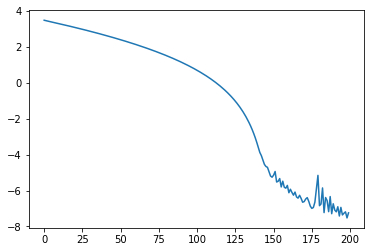

In [ ]:
plt.plot(losses)

In [ ]:
list(k.parameters())

[Parameter containing:
 tensor([[1.3400094509]], requires_grad=True),
 Parameter containing:
 tensor([0.4287530482], requires_grad=True),
 Parameter containing:
 tensor([[0.1470584720]], requires_grad=True),
 Parameter containing:
 tensor([[0.1455851793]], requires_grad=True),
 Parameter containing:
 tensor([-0.4134024680], requires_grad=True),
 Parameter containing:
 tensor([[0.0268113427]], requires_grad=True),
 Parameter containing:
 tensor([0.4979022741], requires_grad=True),
 Parameter containing:
 tensor([[0.1377424598]], requires_grad=True)]

## Other

### Testing

### Fuzzing smoother

trying to run the filter many times to see if some of the matrix are not symmetric

In [ ]:
from torch._C import _LinAlgError

In [ ]:
def fuzz_symmetric(n_iter=10, n_obs=100, **kwargs):
    tst = KalmanFilterTester(n_obs=n_obs, **kwargs)
    _, sm_covs = tst.filter.smooth(tst.data, tst.mask)
    i_posdef = []
    for t, cov in enumerate(sm_covs):
        i_posdef.append(check_posdef(cov))
    return pd.concat(i_posdef)
    

In [ ]:
def fuzz_smooth(n_obs=100, **kwargs):
    tst = KalmanFilterTester(n_obs=n_obs, **kwargs)
    _, sm_covs = tst.filter.smooth(tst.data, tst.mask, check_args= {})
    

In [ ]:
def find_max_obs(start=100_000, end=100, steps=10, **kwargs):
    for n in torch.logspace(torch.log10(start), torch.log10(end), 10):
        try:
            %time fuzz_smooth(n_obs=int(n), **kwargs)
            print(n, "working")
            break
        except _LinAlgError:
            print(n, "not working")
    

In [ ]:
import warnings

In [ ]:
posdef_log = pd.DataFrame()

In [ ]:
total_warn = []
for n in range(2, 200):
    with warnings.catch_warnings(record=True) as w:
        try:
            fuzz_smooth(n_obs=n)
        except _LinAlgError:
            print(n)
            break
        finally:
            total_warn.append((n, len(w)))
    

27


In [ ]:
posdef_log

,is_pd_eigv,is_pd_chol,is_sym,sym_upto,eigv,matrix,name,t
0,True,True,True,-8,"[0.0044204406, 0.51171917, 1.1058657]","[[0.07919369, 0.21216275, 0.08634329], [0.2121...",filter_correct,0
0,True,True,True,-8,"[0.14680785, 0.6775383, 5.3274283]","[[2.041435, 1.3869133, 1.601786], [1.3869132, ...",filter_predict,1
0,True,True,True,-8,"[0.14680785, 0.6775383, 5.3274283]","[[2.041435, 1.3869133, 1.601786], [1.3869132, ...",filter_correct,1
0,True,True,True,-8,"[[0.0044204514, 0.5117193, 1.1058657], [0.0959...","[[[0.07919369, 0.21216275, 0.08634329], [0.212...",filter_correct,0
0,True,True,True,-8,"[0.0044204406, 0.51171917, 1.1058657]","[[0.07919369, 0.21216275, 0.08634329], [0.2121...",filter_correct,0
...,...,...,...,...,...,...,...,...
0,True,True,True,-8,"[0.3388391, 0.69478154, 18449.22]","[[7131.8594, 6422.1284, 6281.904], [6422.1284,...",filter_correct,9
0,True,True,True,-8,"[0.33459213, 0.6852231, 77041.47]","[[29782.723, 26819.559, 26233.049], [26819.559...",filter_predict,10
0,True,True,True,-8,"[0.33459213, 0.6852231, 77041.47]","[[29782.723, 26819.559, 26233.049], [26819.559...",filter_correct,10
0,False,False,False,2,"[-797.5366, -56.76306, 29.798246]","[[-327.70764, -295.44025, -289.2465], [-348.85...",filter_predict,11


In [ ]:
import altair as alt

In [ ]:
alt.Chart(pd.DataFrame(total_warn, columns=["n_obs", "n_not_posdef"])).mark_line().encode(alt.X("n_obs"), alt.Y("n_not_posdef"))

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [ ]:
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [ ]:
alt.Chart(posdef_log).mark_line().encode(alt.X("t"), alt.Y("average(sym_upto)"))

alt.Chart(...)

In [ ]:
alt.Chart(posdef_log).mark_point().encode(alt.X("t"), alt.Y("count(is_sym)"))

alt.Chart(...)

In [ ]:
posdef_log[["t", "name"]]

,t,name
0,0,filter_correct
0,1,filter_predict
0,1,filter_correct
0,0,filter_correct
0,0,filter_correct
...,...,...
0,9,filter_correct
0,10,filter_predict
0,10,filter_correct
0,11,filter_predict


<matplotlib.collections.PathCollection>

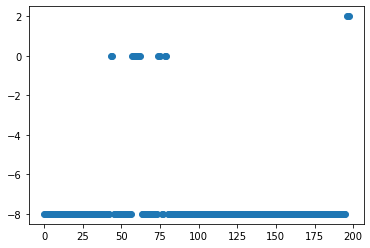

In [ ]:
plt.scatter(posdef_log.reset_index().index, posdef_log.sym_upto)

In [ ]:
for i in range(3):
    %time 1+1

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


In [ ]:
# find_max_obs(dtype=torch.float64)

The function takes 5 min to run so this is the output saved

with `float64` there is no problem with positive definite matrices even with 100k observations
```CPU times: user 30min 43s, sys: 28.6 s, total: 31min 11s
Wall time: 5min 26s
tensor(100000.) working```

In [ ]:
tst = KalmanFilterTester(n_obs=100)

In [ ]:
is_posdef(tst.params['obs_cov'])

True

In [ ]:
is_posdef(tst.params['trans_cov'])

True

In [ ]:
is_posdef(tst.params['init_state_cov'])

True

In [ ]:
tst.filter.smooth(tst.data, tst.mask);

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 1 is not positive-definite).

#### Random Testing

The goal is to generate random set of data and parameters and check that `meteo_imp` implementation is the same of `pykalman` implementation

In [ ]:
n_dim_state = 3 
n_dim_obs = 3
n_obs = 10
p_missing = .3

In [ ]:
to_posdef = PosDef().transform

In [ ]:
data = torch.rand(n_obs, n_dim_obs)
mask = torch.rand(n_obs, n_dim_obs) > p_missing
mask = mask.all(1)

In [ ]:
mask[:10]

In [ ]:
mask[:10]

In [ ]:
params = {
    'trans_matrices': torch.rand(n_dim_state, n_dim_state),
    'trans_offsets':  torch.rand(n_dim_state),        
    'trans_cov':      to_posdef(torch.rand(n_dim_state, n_dim_state)),        
    'obs_matrices':        torch.rand(n_dim_obs, n_dim_state),
    'obs_offsets':         torch.rand(n_dim_obs),          
    'obs_cov':             to_posdef(torch.rand(n_dim_obs, n_dim_obs)),            
    'init_state_mean':  torch.rand(n_dim_state),        
    'init_state_cov':   to_posdef(torch.rand(n_dim_state, n_dim_state)),
}

In [ ]:
params2pyk = {
    'trans_matrices': 'trans_matrices',
    'trans_offsets':  'trans_offsets',        
    'trans_cov':      'trans_covariance',        
    'obs_matrices':        'observation_matrices',
    'obs_offsets':         'observation_offsets',          
    'obs_cov':             'observation_covariance',            
    'init_state_mean':  'init_state_mean',        
    'init_state_cov':   'init_state_covariance',
}

In [ ]:
params

In [ ]:
k = KalmanFilter(**params)

In [ ]:
pred = k.smooth(data, mask)

make a `pykalman` model using the same parameters

In [ ]:
data_pyk = np.ma.masked_array(data.numpy(), mask = mask.numpy())

In [ ]:
pyk_k = pykalman.standard.KalmanFilter(

    trans_matrices=k.trans_matrices.detach().numpy(),
    trans_offsets=k.trans_offsets.detach().numpy(),
    trans_covariance=k.trans_cov.detach().numpy(),
    observation_matrices=k.obs_matrices.detach().numpy(),
    observation_offsets=k.obs_offsets.detach().numpy(),
    observation_covariance=k.obs_cov.detach().numpy(),
    init_state_mean=k.init_state_mean.detach().numpy(),
    init_state_covariance=k.init_state_cov.detach().numpy()
)

In [ ]:
pred_pyk = pyk_k.smooth(data_pyk)

In [ ]:
for p in params.keys():
    print(p, getattr(k, p))

In [ ]:
for p in params.keys():
    print(p, getattr(pyk_k, params2pyk[p]))

### Compare Statsmodels

In [ ]:
import statsmodels.api as sm
import statsmodels

In [ ]:
# sm_kf = statsmodels.tsa.statespace.kalman_filter.KalmanFilter(
#     k_endog = 3,
#     k_states = 3,
#     initization = 'known',
#     init_state = pyk_ncov.init_state_mean,
#     init_state_cov = pyk_ncov.init_state_covariance,
#     design = pyk_ncov.observation_matrices,
#     obs_cov = pyk_ncov.observation_covariance,
#     trans = pyk_ncov.trans_matrices,
#     state_cov = pyk_ncov.trans_covariance)

In [ ]:
# sm_kf.bind(X_ncov.detach().numpy())

In [ ]:
# sm_pred = sm_kf.filter() 

In [ ]:
# sm_pred.predicted_state.shape

In [ ]:
# sm_pred.predicted_state_cov.shape

In [ ]:
# mean = MultivariateNormal(torch.tensor(sm_pred.predicted_state[:, 0]), torch.tensor(sm_pred.predicted_state_cov[:, :, 0]))

In [ ]:
# sm_kf.loglikeobs()

## Export

In [ ]:
#| hide
from nbdev import nbdev_export
# nbdev_export()